In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 绘图参数

In [2]:
# 绘图参数
params = {'font.family'    : 'serif',  # 衬线字体族
          'font.serif'     : 'Times New Roman',
          'legend.fontsize': 20,
          # 'figure.dpi'     : 100,
          'savefig.dpi'    : 600,
        #   'figure.figsize' : (15, 5),
          'axes.labelsize' : 20,
          'axes.titlesize' : 20,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          }
plt.rcParams.update(params)

In [3]:
# 路径下的所有txt文件
file = [i for i in os.listdir('.') if i.endswith('.txt')]

In [4]:
file

['1-CV 1 M KOH 20cycles(0.1~0.6V) NiCo2O4.txt',
 '2.3-LSV 1 M KOH OER OCP-0.1975 iR-95%-1.3Ω (0~0.8V) NiCo2O4.txt',
 '3-EIS 0.6357V-NiCo2O4.txt',
 '4.1-Cdl-10 mV s-1.txt',
 '4.2-Cdl-20 mV s-1.txt',
 '4.3-Cdl-40 mV s-1.txt',
 '4.4-Cdl-60 mV s-1.txt',
 '4.5-Cdl-80 mV s-1.txt',
 '4.6-Cdl-100 mV s-1.txt']

In [6]:
keywords = ['CV', 'LSV', 'EIS', 'Cdl']
cv  = list(filter(lambda text: all([keyword in text for keyword in [keywords[0]]]), file ))
lsv = list(filter(lambda text: all([keyword in text for keyword in [keywords[1]]]), file ))
eis = list(filter(lambda text: all([keyword in text for keyword in [keywords[2]]]), file ))
cdl = list(filter(lambda text: all([keyword in text for keyword in [keywords[3]]]), file ))

In [7]:
cv, lsv, eis, cdl

(['1-CV 1 M KOH 20cycles(0.1~0.6V) NiCo2O4.txt'],
 ['2.3-LSV 1 M KOH OER OCP-0.1975 iR-95%-1.3Ω (0~0.8V) NiCo2O4.txt'],
 ['3-EIS 0.6357V-NiCo2O4.txt'],
 ['4.1-Cdl-10 mV s-1.txt',
  '4.2-Cdl-20 mV s-1.txt',
  '4.3-Cdl-40 mV s-1.txt',
  '4.4-Cdl-60 mV s-1.txt',
  '4.5-Cdl-80 mV s-1.txt',
  '4.6-Cdl-100 mV s-1.txt'])

In [32]:
shift = 0.9181  # 电极转换电势
area = 2        # 工作电极表面积

## CV数据处理

In [82]:
# 读取并处理CV数据
cv_data = pd.read_table(cv[0], index_col=None, header=None, skiprows=0, sep=',')

# 读取CV扫速、电势窗口范围和数据开始的行索引
scan_rate_cv = cv_data[cv_data.iloc[:,0].str.contains("Scan Rate")].iloc[0,0].split(sep=' ')[-1]
low_E_cv = cv_data[cv_data.iloc[:,0].str.contains("Low E")].iloc[0,0].split(sep=' ')[-1]
high_E_cv = cv_data[cv_data.iloc[:,0].str.contains("High E")].iloc[0,0].split(sep=' ')[-1]
index_cv = cv_data[cv_data.iloc[:,0].isin(['Potential/V'])].index.tolist()[0] + 1

In [83]:
# 将CV数据转换为相对于RHE并与源数据合并在一起
cv_data_new = cv_data.iloc[index_cv:,:].rename(columns={0:'Potential(V)', 1:'Current(A)'})   # 删除字符信息，只保留数值部分
cv_Potential_RHE = cv_data.iloc[index_cv:,0].astype(float).rename('Potential(V vs. RHE)') + shift   # 相对于RHE的电压
cv_Current_density_RHE = cv_data.iloc[index_cv:,1].astype(float).rename('Current density(mA/cm2 vs. RHE)')*1000/area   # 电流密度
cv_data_RHE  = pd.concat([cv_data_new, cv_Potential_RHE, cv_Current_density_RHE], axis=1).reset_index(drop=True)   # 合并源数据和转化后的数据

## LSV数据处理

In [88]:
# 读取并处理LSV数据
lsv_data = pd.read_table(lsv[0], index_col=None, header=None, skiprows=0, sep=',')

# 读取lsv扫速、电势窗口范围和数据开始的行索引
scan_rate_lsv = lsv_data[lsv_data.iloc[:,0].str.contains("Scan Rate")].iloc[0,0].split(sep=' ')[-1]
init_E_lsv = lsv_data[lsv_data.iloc[:,0].str.contains("Init E")].iloc[0,0].split(sep=' ')[-1]
final_E_lsv = lsv_data[lsv_data.iloc[:,0].str.contains("Final E")].iloc[0,0].split(sep=' ')[-1]
index_lsv = lsv_data[lsv_data.iloc[:,0].isin(['Potential/V'])].index.tolist()[0] + 1

In [216]:
# 将LSV数据转换为相对于RHE并与源数据和Tafel数据合并在一起
lsv_data_new = lsv_data.iloc[index_lsv:,:].rename(columns={0:'Potential(V)', 1:'Current(A)'})   # 删除字符信息，只保留数值部分
lsv_Potential_RHE = lsv_data.iloc[index_lsv:,0].astype(float).rename('Potential(V vs. RHE)') + shift   # 相对于RHE的电压
lsv_Current_density_RHE = lsv_data.iloc[index_lsv:,1].astype(float).rename('Current density(mA/cm2 vs. RHE)')*1000/area   # 电流密度
tafel_Current_density = np.log(np.abs(lsv_data.iloc[index_lsv:,1].astype(float)*1000/area))
tafel_Potential = lsv_data.iloc[index_lsv:,0].astype(float)+shift-1.23

lsv_data_RHE  = pd.concat([lsv_data_new, 
                           lsv_Potential_RHE, lsv_Current_density_RHE, 
                           tafel_Current_density, tafel_Potential], 
                           axis=1).reset_index(drop=True)   # drop=True删除原来的索引

## EIS数据处理

In [184]:
# 读取并处理EIS数据
eis_data = pd.read_table(eis[0], index_col=None, header=None, skiprows=0)

# 读取EIS初始点位、频率窗口范围、扰动和数据开始的行索引
init_E_eis = eis_data[eis_data.iloc[:,0].str.contains("Init E")].iloc[0,0].split(sep=' ')[-1]
low_frequency_eis = eis_data[eis_data.iloc[:,0].str.contains("Low Frequency")].iloc[0,0].split(sep=' ')[-1]
high_frequency_eis = eis_data[eis_data.iloc[:,0].str.contains("High Frequency")].iloc[0,0].split(sep=' ')[-1]
amplitude_eis = eis_data[eis_data.iloc[:,0].str.contains("Amplitude")].iloc[0,0].split(sep=' ')[-1]
index_eis = eis_data[eis_data.iloc[:,0].str.contains("Freq/Hz")].index.tolist()[0] + 1

In [227]:
# 去除多余的字符信息
eis_data_new = eis_data.iloc[index_eis:,:]   # 删除字符信息，只保留数值部分
eis_data_new_split = eis_data_new.iloc[:,0].str.split(',', expand=True).rename(columns={0:'Freq/Hz',1:"Z'/ohm",2:'Z"/ohm',3:'Z/ohm',4:'Phase/deg'})  # 按照逗号分列并修改列名
eis_data_new_split = eis_data_new_split.astype(float)

## $C_{dl}$数据处理

In [256]:
# 转换不同扫速Cdl的数据用于Cdl计算
def ref_to_RHE(cdl):
    # 读取并处理Cdl数据
    cdl_data = pd.read_table(cdl, index_col=None, header=None, skiprows=0, sep=',')

    # 读取Cdl扫速、电势窗口范围、segment数和数据开始的行索引
    scan_rate_cdl = cdl_data[cdl_data.iloc[:,0].str.contains("Scan Rate")].iloc[0,0].split(sep=' ')[-1]
    low_E_cdl = cdl_data[cdl_data.iloc[:,0].str.contains("Low E")].iloc[0,0].split(sep=' ')[-1]
    high_E_cdl = cdl_data[cdl_data.iloc[:,0].str.contains("High E")].iloc[0,0].split(sep=' ')[-1]
    segment_cdl = cdl_data[cdl_data.iloc[:,0].str.contains("Segment")].iloc[0,0].split(sep=' ')[-1]
    sample_interval_cdl = cdl_data[cdl_data.iloc[:,0].str.contains("Sample Interval")].iloc[0,0].split(sep=' ')[-1]
    index_cdl = cdl_data[cdl_data.iloc[:,0].isin(['Potential/V'])].index.tolist()[0] + 1

    # 将Cdl数据转换为相对于RHE并与源数据合并在一起
    cdl_data_new = cdl_data.iloc[index_cdl:,:].rename(columns={0:'Potential(V)', 1:'Current(A)'})   # 删除字符信息，只保留数值部分
    cdl_Potential_RHE = cdl_data.iloc[index_cdl:,0].astype(float).rename('Potential(V vs. RHE) {}mV/s'.format(int(float(scan_rate_cdl)*1000))) + shift   # 相对于RHE的电压
    cdl_Current_density_RHE = cdl_data.iloc[index_cdl:,1].astype(float).rename('Current density(mA/cm2 vs. RHE) {}mV/s'.format(int(float(scan_rate_cdl)*1000)))*1000/area   # 电流密度
    cdl_data_RHE  = pd.concat([cdl_Potential_RHE, cdl_Current_density_RHE], axis=1).reset_index(drop=True)   # 合并源数据和转化后的数据
    
    return(cdl_data_RHE, scan_rate_cdl, low_E_cdl, high_E_cdl, segment_cdl, sample_interval_cdl)

In [202]:
# 合并所有转换后的Cdl数据
cdl_data_RHE = pd.concat([ref_to_RHE(i)[0] for i in cdl], axis=1)

In [269]:
# 整理Cdl数据用于绘图
cdl_data_RHE_x = cdl_data_RHE.iloc[:,0]  # 一列电压值，即第一列
cdl_data_RHE_y = cdl_data_RHE.iloc[:, [i%2==1 for i in range(len(cdl_data_RHE.columns))]]  # 多列电流值，即奇数列

# 电流密度差数据
scan_rates_cdl = [int(float(ref_to_RHE(i)[1])*1000) for i in cdl]    # 扫速
low_E_cdl = float(ref_to_RHE(cdl[0])[2])
high_E_cdl = float(ref_to_RHE(cdl[0])[3])
segment_cdl = int(float(ref_to_RHE(cdl[0])[4]))         # 圈数
sample_interval_cdl = float(ref_to_RHE(cdl[0])[5])      # 采样间隔
sample_num = int((high_E_cdl-low_E_cdl)/sample_interval_cdl)   # 一个segment(半圈)的采样数

cdl_row_number = cdl_data_RHE.shape[0]   # Cdl数据的行数
ja = cdl_data_RHE_y.iloc[int(-sample_num*1.5),:]
jc = cdl_data_RHE_y.iloc[int(-sample_num*0.5),:]
j_diff = (ja-jc)/2*1000/2

# 线性拟合
fit = np.polyfit(scan_rates_cdl, j_diff, 1)
y_fit = np.poly1d(fit)
y_fit_data = y_fit(scan_rates_cdl)

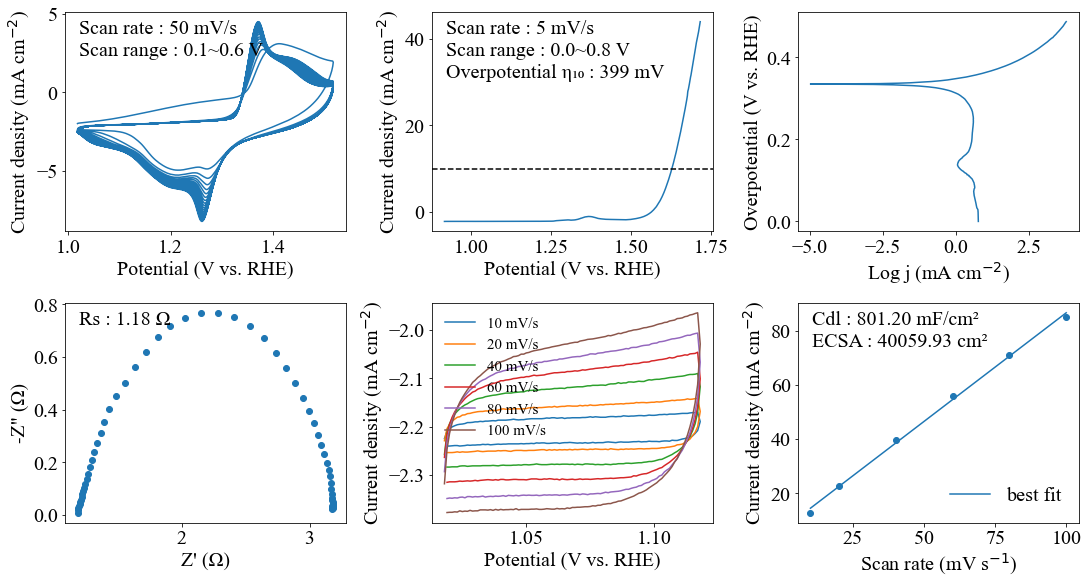

In [281]:
# 绘制电化学数据图
fig, axs = plt.subplots(2, 3, figsize=(15, 8), constrained_layout=True)

# CV
axs[0,0].plot(cv_data_RHE.iloc[:,2], cv_data_RHE.iloc[:,3])
axs[0,0].set_xlabel("Potential (V vs. RHE)")
axs[0,0].set_ylabel("Current density (mA cm$^{-2}$)")
axs[0,0].annotate("Scan rate : {:.0f} mV/s".format(float(scan_rate_cv)*1000), xy=(.05, .9), xycoords='axes fraction', fontsize=20)
axs[0,0].annotate("Scan range : {:.1f}~{:.1f} V".format(float(low_E_cv),float(high_E_cv)), xy=(.05, .8), xycoords='axes fraction', fontsize=20)

# LSV
axs[0,1].plot(lsv_data_RHE.iloc[:,2], lsv_data_RHE.iloc[:,3])
axs[0,1].axhline(y=10, c='k', ls='--')
axs[0,1].set_xlabel("Potential (V vs. RHE)")
axs[0,1].set_ylabel("Current density (mA cm$^{-2}$)")
closest_10_index = (lsv_data_RHE.iloc[:,3]-10).abs().argsort()[0]    # 电流密度最接近10的行索引
overpotential = (lsv_data_RHE.iloc[closest_10_index,2] - 1.23)*1000  # 过电位
axs[0,1].annotate("Scan rate : {:.0f} mV/s".format(float(scan_rate_lsv)*1000), xy=(.05, .9), xycoords='axes fraction', fontsize=20)
axs[0,1].annotate("Scan range : {:.1f}~{:.1f} V".format(float(init_E_lsv),float(final_E_lsv)), xy=(.05, .8), xycoords='axes fraction', fontsize=20)
axs[0,1].annotate("Overpotential η₁₀ : {:.0f} mV".format(overpotential), xy=(.05, .7), xycoords='axes fraction', fontsize=20)

# Tafel
tafel_data = lsv_data_RHE.iloc[:,[4, 5]]
tafel_data_new = tafel_data[(tafel_data.iloc[:,1] > 0)]  # 删除Tafel曲线中y坐标小于零的部分
axs[0,2].plot(tafel_data_new.iloc[:,0], tafel_data_new.iloc[:,1])
axs[0,2].set_xlabel("Log j (mA cm$^{-2}$)")
axs[0,2].set_ylabel("Overpotential (V vs. RHE)")

# EIS
eis_data_ = eis_data_new_split[(eis_data_new_split.iloc[:,2] < 0)]  # 删除EIS散点图中y坐标小于零的部分
axs[1,0].scatter(eis_data_.iloc[:,1], -eis_data_.iloc[:,2])
axs[1,0].set_xlabel("Z' (Ω)")
axs[1,0].set_ylabel('-Z" (Ω)')
axs[1,0].annotate("Rs : {:.2f} Ω".format(eis_data_.iloc[:,1].min()), xy=(.05, .9), xycoords='axes fraction', fontsize=20)


# CV curves with different scan rates
for i, j in zip(range(cdl_data_RHE_y.shape[1]), scan_rates_cdl):
    axs[1,1].plot(cdl_data_RHE_x[-int(sample_num*2):], 
                  cdl_data_RHE_y.iloc[-int(sample_num*2):,i], 
                  label="{} mV/s".format(j))
axs[1,1].legend(fontsize=15, frameon=False)
axs[1,1].set_xlabel("Potential (V vs. RHE)")
axs[1,1].set_ylabel("Current density (mA cm$^{-2}$)")

# Cdl and ECSA
axs[1,2].scatter(scan_rates_cdl, j_diff)
axs[1,2].plot(scan_rates_cdl, y_fit_data, label="best fit")
axs[1,2].set_xlabel("Scan rate (mV s$^{-1}$)")
axs[1,2].set_ylabel("Current density (mA cm$^{-2}$)")
axs[1,2].legend(fontsize=20, frameon=False, loc='lower right')
axs[1,2].annotate("Cdl : {:.2f} mF/cm²".format(fit[0]*1000), xy=(.05, .9), xycoords='axes fraction', fontsize=20)
axs[1,2].annotate("ECSA : {:.2f} cm²".format(fit[0]*1000/0.04*area), xy=(.05, .8), xycoords='axes fraction', fontsize=20)

# plt.savefig('results.png', facecolor ="w")
plt.show()

Text(0, 0.5, 'Overpotential (V vs. RHE)')

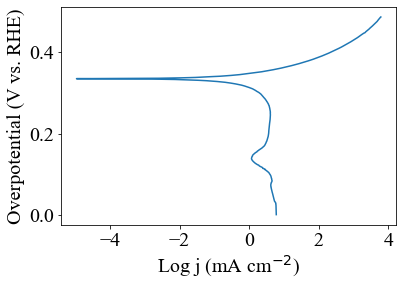

In [282]:
tafel_data = lsv_data_RHE.iloc[:,[4, 5]]
tafel_data_new = tafel_data[(tafel_data.iloc[:,1] > 0)]  # 删除Tafel曲线中y坐标小于零的部分
plt.plot(tafel_data_new.iloc[:,0], tafel_data_new.iloc[:,1])
plt.xlabel("Log j (mA cm$^{-2}$)")
plt.ylabel("Overpotential (V vs. RHE)")